# Biophysical self-organization amplifies the resilience of salt marshes

The tensile stress, humidity of soil surface, water content, and plant biomass are defined as 𝑆(𝒓, 𝑡), 𝐸(𝒓, 𝑡), 𝑊(𝒓, 𝑡), and 𝑃(𝒓, 𝑡) at position 𝒓 = (𝑥, 𝑦) and time 𝑡, respectively. 

$\frac{\partial S}{\partial t} = r_S (S-S_{min}) (S_{critical}-S) (S-S_{max}) + c_S (E - e)$

$\frac{\partial W}{\partial t} = \frac{c_W}{k_W + S} - d_E (E - e) W - l_P P \frac{W}{k_P+W} + D_W\mathrm{\Delta W}$

$\frac{\partial E}{\partial t} = r_E (W - h) (E - e) + D_E \mathrm{\Delta E}$

$\frac{\partial P}{\partial t} = r_P \frac{W(1-S)}{k_P+W} P - d_P P^2 + D_P \mathrm{\Delta P}$

In [1]:
%reset -f

### Loading some crucial python packages

In [2]:
import time,os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# Widening the screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
FS=25
rcParams['figure.dpi'] = 1800
rcParams['savefig.dpi'] = 800
rcParams['font.size'] = FS
rcParams['font.family'] = 'StixGeneral'#'Times New Roman'
rcParams["mathtext.fontset"] = 'stix'
# rcParams["mathtext.default"] = "rm" 
#rcParams['xtick.direction'] = 'in'
plt.rc('font', size=FS)          # controls default text sizes
plt.rc('axes', titlesize=FS)     # fontsize of the axes title
plt.rc('axes', labelsize=FS)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=FS)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FS)    # fontsize of the tick labels
plt.rc('legend', fontsize=FS)    # legend fontsize
plt.rc('figure', titlesize=FS)   # fontsize of the figure title

### Parameter definitions 
Here, the parameters that are found in the equations are given their value.

In [3]:
#tensile stress
rS   = 0.3
Smin = 0.0001 
Smax = 0.3    
Scri = 0.15   
cS   = 0.0015
e    = 1.0
#water content
cW   = 0.001125
kW   = 0.05
dE   = 0.025
lP   = 0.039
kP   = 1.0
DW   = 0.3
#humidity of soil surface
rE   = 0.25
h    = 1.0
DE   = 0.15
#plant biomass
rP   = 0.25
dP   = 0.25
DP   = 0.015

### Simulation settings

In [4]:
length    = 300.0    # Length of the physical landscape
n         = 512      # Size of the 2D grid
endtime   = 15000.0  # End time
dT        = 0.02     # Calculate time step
nplot     = 100
nsteps    = np.ceil(endtime/nplot/dT).astype(int)   #number of time steps
dX          = length/n   # Spatial step size
dY          = length/n   # Spatial step size
Grid_Width  = n
Grid_Height = n
# %% Reporting in the simulation on the console
print(" Current grid dimensions: %d x %d cells\n" % (Grid_Width, Grid_Height));

 Current grid dimensions: 512 x 512 cells



### Defining the device that is used

In [5]:
import pyopencl as cl
# Setting up the OpenCL context
DeviceNr = 1   # 0 = GTX 960M
platform = cl.get_platforms()
Devices  = platform[0].get_devices()  # 0 = GPU
context  = cl.Context([Devices[DeviceNr]])
queue    = cl.CommandQueue(context)
mf       = cl.mem_flags # Memory flags are set
print(" Compute Device: %s\n" % Devices[DeviceNr].name)

 Compute Device: AMD Radeon Pro Vega 64X Compute Engine



### Initial values

In [6]:
# The array is allocated on the GPU and the initial values are copied onto it
#tensile stress
S        = np.ones((n*n),dtype=float)*0.0
S_host   = S.astype(np.float32)
S_g      = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=S_host)
#water content
W        = np.ones((n*n),dtype=float)*3.0
W_host   = W.astype(np.float32)
W_g      = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=W_host)
#humidity of soil surface
E        = (np.random.rand(n*n)>0.9996)*1.0+1.0
E_host   = E.astype(np.float32)
E_g      = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=E_host)
#plant biomass
P        = np.ones((n*n),dtype=float)*1.0
P_host   = P.astype(np.float32)
P_g      = cl.Buffer(context, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=P_host)

### Loading the functions d2_dxy2() and Periodicboundaries()

In [7]:
with open('SpatialFunctions_iPy.cl', 'r') as myfile:
   SpatialFunctions = myfile.read()

### List of parameters for the OpenCL kernel.

In [8]:
# Setting up the parameters for the Kernel
PassVars="rS,Smin,Smax,Scri,cS,e, cW,kW,dE,lP,kP,DW, rE,h,DE, rP,dP,DP, dX,dY,dT,Grid_Width,Grid_Height"

PassVals=eval(PassVars)
PassVars=PassVars.split(',')
Params=""

for ii in range(len(PassVals)):
    Params = Params+"#define " + PassVars[ii] + " " + str(PassVals[ii]) + " \n"

### Defining the OpenCL simulation kernel

In [9]:
ComputeCode = """

///////////////////////////////////////////////////////////////////////////////
// Simulation kernel
///////////////////////////////////////////////////////////////////////////////   

__kernel void SimulationKernel (__global float* S, __global float* W, __global float* E, __global float* P)
{

    size_t current  = get_global_id(0);
    size_t row      = floor((float)current/(float)Grid_Width);
    size_t column   = current%Grid_Width;

        if (row > 0 && row < Grid_Width-1 && column > 0 && column < Grid_Height-1)
            {                
             float dSdt =   rS*(S[current]-Smin)*(S[current]-Smax)*(Scri-S[current]) + cS*(E[current]-e);
             float dWdt =   cW/(kW+S[current]) - dE*(E[current]-e)*W[current] - lP*W[current]*P[current]/(kP+W[current]) + DW*d2_dxy2(W);
             float dEdt =   rE*(W[current] - h)*(E[current]-e) + DE*d2_dxy2(E);
             float dPdt =   rP*P[current]*(1.0-S[current])*W[current]/(kP+W[current]) - dP*P[current]*P[current] + DP*d2_dxy2(P);
             
             S[current] = S[current] + dSdt*dT;
             W[current] = W[current] + dWdt*dT;
             E[current] = E[current] + dEdt*dT;
             P[current] = P[current] + dPdt*dT;
             
             //S[current]=(S[current]>0)*S[current];
             //W[current]=(W[current]>0)*W[current];
             //E[current]=(E[current]>0)*E[current];
             //P[current]=(P[current]>0)*P[current];
            }
            
        // HANDLE Boundaries
        else 
            {
             PeriodicBoundaries(S);
             PeriodicBoundaries(W);
             PeriodicBoundaries(E);
             PeriodicBoundaries(P);
            }

} // End SimulationKernel
"""

### Here the kernel is compiled

In [10]:
program = cl.Program(context, Params + SpatialFunctions + ComputeCode).build()

### The main simulation loop

In [11]:
from ipywidgets import FloatProgress
from IPython.display import display

# Setting up a progress bar for the simulation
print("Progress :");
PB = FloatProgress(min=0, max=nplot); display(PB) 

Ss=np.zeros((Grid_Width, Grid_Height, nplot))
Ws=np.zeros((Grid_Width, Grid_Height, nplot))
Es=np.zeros((Grid_Width, Grid_Height, nplot))
Ps=np.zeros((Grid_Width, Grid_Height, nplot))

# Set up simulation parameters
global_size = P_host.shape

# Start the timer:
start_time = time.time()

# Starting the loop
for ii in range(1,nplot):
    # The simulation
    # We store the state of the system for <NumPlot> different times.
    Ss[:,:,ii] = S_host.reshape(Grid_Width, Grid_Height)
    Ws[:,:,ii] = W_host.reshape(Grid_Width, Grid_Height)
    Es[:,:,ii] = E_host.reshape(Grid_Width, Grid_Height)
    Ps[:,:,ii] = P_host.reshape(Grid_Width, Grid_Height)
    
    for jj in range(nsteps):      
        program.SimulationKernel(queue, global_size, None, S_g, W_g, E_g, P_g)

    # Get the data from the GPU
    cl.enqueue_copy(queue, S_host, S_g)
    cl.enqueue_copy(queue, W_host, W_g)
    cl.enqueue_copy(queue, E_host, E_g)
    cl.enqueue_copy(queue, P_host, P_g)

    PB.value += 1 # signal to increment the progress bar
#     print(ii)

# Determining the time that we used for the simulation
elapsed_time = time.time() - start_time    
print(" Simulation took      : %1.1f (s)" % (elapsed_time))

Progress :


FloatProgress(value=0.0)

 Simulation took      : 181.4 (s)


### Plotting the results

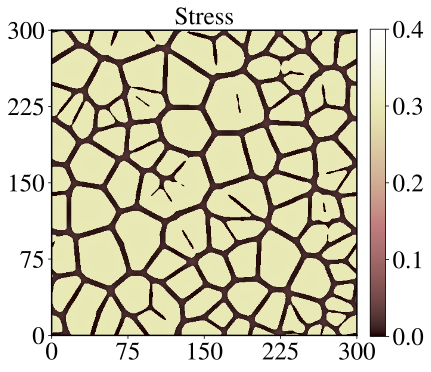

In [12]:
#tensile stress
nticker = 5
from matplotlib import ticker
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
im0 = ax.imshow(S_host.reshape(n,n),cmap='pink',extent=[0,length,0,length], clim=(0,0.4));

ax.set_title('Stress',fontsize=25);
# ax.set_xlabel('Initial stone concentrations, $\mathcal{S}_0$ [g/cm$^2$]');
# ax.set_ylabel('Movement speed decay rate, $\lambda$');
cbar=plt.colorbar(im0, ax=ax,fraction=0.046,pad=0.04);
# ax[0].set_yticks(np.linspace(0,length,nticker))
tick_locator = ticker.MaxNLocator(nbins=4)
cbar.locator = tick_locator
cbar.update_ticks()
# Xlabels = np.logspace(np.log10(S0_min),np.log10(S0_max),nticker).round(1)
# Ylabels = np.linspace((Lambda_min),(Lambda_max),nticker).round(1)
ax.set_xticks(np.linspace(0,length,nticker))
# ax.set_xticklabels(Xlabels)
ax.set_yticks(np.linspace(0,length,nticker))
# ax.set_yticklabels(Ylabels)
ax.spines['bottom'].set_linewidth(1.5);
ax.spines['left'].set_linewidth(1.5);
ax.spines['right'].set_linewidth(1.5);
ax.spines['top'].set_linewidth(1.5);
plt.savefig('Fig3p4Simulations-Stress.pdf', bbox_inches='tight')

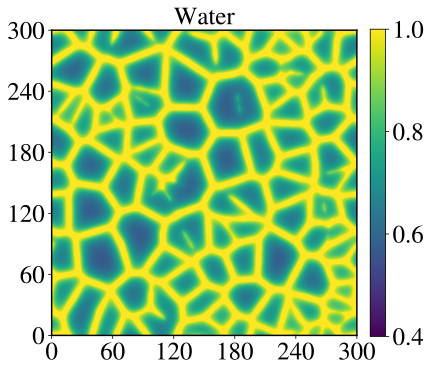

In [13]:
#water content
nticker = 6
from matplotlib import ticker
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
im0 = ax.imshow(W_host.reshape(n,n),cmap='viridis',extent=[0,length,0,length], clim=(0.4,1.0));

ax.set_title('Water',fontsize=25);
# ax.set_xlabel('Initial stone concentrations, $\mathcal{S}_0$ [g/cm$^2$]');
# ax.set_ylabel('Movement speed decay rate, $\lambda$');
cbar=plt.colorbar(im0, ax=ax,fraction=0.046,pad=0.04);
# ax[0].set_yticks(np.linspace(0,length,nticker))
tick_locator = ticker.MaxNLocator(nbins=3)
cbar.locator = tick_locator
cbar.update_ticks()
# Xlabels = np.logspace(np.log10(S0_min),np.log10(S0_max),nticker).round(1)
# Ylabels = np.linspace((Lambda_min),(Lambda_max),nticker).round(1)
ax.set_xticks(np.linspace(0,length,nticker))
# ax.set_xticklabels(Xlabels)
ax.set_yticks(np.linspace(0,length,nticker))
# ax.set_yticklabels(Ylabels)
ax.spines['bottom'].set_linewidth(1.5);
ax.spines['left'].set_linewidth(1.5);
ax.spines['right'].set_linewidth(1.5);
ax.spines['top'].set_linewidth(1.5);
plt.savefig('Fig3p5Simulations-Water.pdf', bbox_inches='tight')

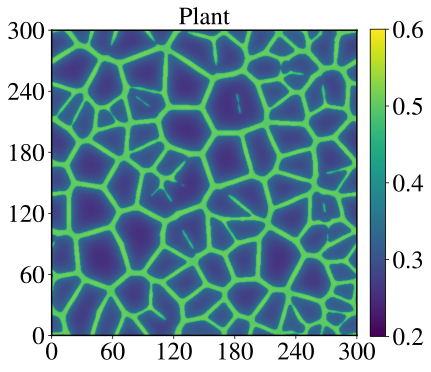

In [14]:
#plant biomass
nticker = 6
orig_map=plt.cm.get_cmap('summer') # 'YlGn', 'summer', 'viridis'
reversed_map = orig_map.reversed()
from matplotlib import ticker
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
im0 = ax.imshow(P_host.reshape(n,n),cmap='viridis',extent=[0,length,0,length], clim=(0.2,0.6));

ax.set_title('Plant',fontsize=25);
# ax.set_xlabel('Initial stone concentrations, $\mathcal{S}_0$ [g/cm$^2$]');
# ax.set_ylabel('Movement speed decay rate, $\lambda$');
cbar=plt.colorbar(im0, ax=ax,fraction=0.046,pad=0.04);
# ax[0].set_yticks(np.linspace(0,length,nticker))
tick_locator = ticker.MaxNLocator(nbins=4)
cbar.locator = tick_locator
cbar.update_ticks()
# Xlabels = np.logspace(np.log10(S0_min),np.log10(S0_max),nticker).round(1)
# Ylabels = np.linspace((Lambda_min),(Lambda_max),nticker).round(1)
ax.set_xticks(np.linspace(0,length,nticker))
# ax.set_xticklabels(Xlabels)
ax.set_yticks(np.linspace(0,length,nticker))
# ax.set_yticklabels(Ylabels)
ax.spines['bottom'].set_linewidth(1.5);
ax.spines['left'].set_linewidth(1.5);
ax.spines['right'].set_linewidth(1.5);
ax.spines['top'].set_linewidth(1.5);
plt.savefig('Fig3p6Simulations-Plant.pdf', bbox_inches='tight')

### Making an animation

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
im0 = ax[0].imshow(S_host.reshape(n,n),cmap='pink',extent=[0,length,0,length], clim=(0,0.4));
plt.colorbar(im0, ax=ax[0],fraction=0.046,pad=0.04);ax[0].set_title('Stress');

im1 = ax[1].imshow(W_host.reshape(n,n),cmap='viridis',extent=[0,length,0,length], clim=(0.4,1.0));
plt.colorbar(im1, ax=ax[1],fraction=0.046,pad=0.04);ax[1].set_title('Water');

im2 = ax[2].imshow(P_host.reshape(n,n),cmap='viridis',extent=[0,length,0,length], clim=(0.2,0.6));
plt.colorbar(im2, ax=ax[2],fraction=0.046,pad=0.04);ax[2].set_title('Plant');

# text=fig.suptitle("Time: %1.0f of %1.0f" % (endtime, endtime), x=0.5, y=0.07, fontsize=16);
ax[0].spines['bottom'].set_linewidth(1.5);
ax[0].spines['left'].set_linewidth(1.5);
ax[0].spines['right'].set_linewidth(1.5);
ax[0].spines['top'].set_linewidth(1.5);
ax[1].spines['bottom'].set_linewidth(1.5);
ax[1].spines['left'].set_linewidth(1.5);
ax[1].spines['right'].set_linewidth(1.5);
ax[1].spines['top'].set_linewidth(1.5);
ax[2].spines['bottom'].set_linewidth(1.5);
ax[2].spines['left'].set_linewidth(1.5);
ax[2].spines['right'].set_linewidth(1.5);
ax[2].spines['top'].set_linewidth(1.5);
# plt.savefig('Crack based on Stress-Water-Plant2021.pdf', bbox_inches='tight')
plt.show()

In [16]:
from matplotlib import animation, rc

def updatefig(i): # To update the image at each iteration
    global Ss, Ws, Ps
    im0.set_array(Ss[:,:,i])
    im1.set_array(Ws[:,:,i])
    im2.set_array(Ps[:,:,i])
    #text.set_text("Time: %1.0f of %1.0f" % ((i+1)/nplot*endTime, EndTime));
    return im0,im1,im2

ani = animation.FuncAnimation(fig, updatefig, interval=100, frames = nplot, repeat=False, blit=True)

In [17]:
# from IPython.display import HTML
# HTML(ani.to_html5_video())

# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=10, bitrate=1800)
# ani.save('Crack based on Stress-Water-Plant2021.mp4', writer=writer)
# print("Save movies finshes!")

### Plotting the results in one dimension

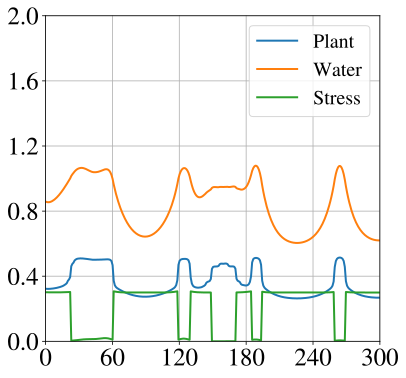

In [18]:
### The Simulation loop
nticker = 6
from matplotlib import ticker
fig1, ax = plt.subplots(1, 1, figsize=(6, 6))
npx = np.linspace(0,n,n)
line10, = ax.plot(npx, Ps[100,:,99], lw=2, label='Plant'); 
line11, = ax.plot(npx, Ws[100,:,99], lw=2, label='Water'); 
line12, = ax.plot(npx, Ss[100,:,99], lw=2, label='Stress'); 
# line13, = ax.plot(npx, Es[100,:,99], lw=2, label='Humidity'); 
# ax.set_title('Plant');
# ax.set_xlabel('Initial stone concentrations, $\mathcal{S}_0$ [g/cm$^2$]');
# ax.set_ylabel('Movement speed decay rate, $\lambda$');
# cbar=plt.colorbar(im0, ax=ax,fraction=0.046,pad=0.04);
# ax[0].set_yticks(np.linspace(0,length,nticker))
# tick_locator = ticker.MaxNLocator(nbins=6)
# cbar.locator = tick_locator
# cbar.update_ticks()
ax.set_xlim(0, 300)
ax.set_ylim(0, 2.0)
# Xlabels = np.linspace(0,300,nticker)
Ylabels = np.linspace(0,2.0,nticker).round(1)
ax.set_xticks(np.linspace(0,300,nticker))
# ax.set_xticklabels(Xlabels)
ax.set_yticks(np.linspace(0,2.0,nticker))
ax.set_yticklabels(Ylabels)
ax.legend(fontsize=20)
ax.grid()
# plt.plot(Ys[100,:,99], label='Y stress'); 

# plt.plot(Ss[100,:,99], label='S water'); 

# plt.plot(As[100,:,99], label='A plant'); 

# plt.plot(Ps[100,:,99], label='P plant'); 

# plt.legend()
# plt.show()
plt.savefig('Fig3p3Simulations-line.pdf', bbox_inches='tight')

In [19]:
### Making an animation

In [20]:
from matplotlib import animation, rc
import os
if not os.path.exists("oldSim"):
    os.makedirs("oldSim")

def updatefig1(i): # To update the image at each iteration
    global Ps, Ws, Ss
    line10.set_data( (npx,Ps[:,100,i]) )
    line11.set_data( (npx,Ws[:,100,i]) )
    line12.set_data( (npx,Ss[:,100,i]) )
    #text.set_text("Time: %1.0f of %1.0f" % ((i+1)/nplot*endTime, EndTime));
    fig.savefig('oldSim/Sulfide'+str(i)+'.pdf')
    return line10,line11,line12
ani = animation.FuncAnimation(fig1, updatefig1)

In [21]:
# from IPython.display import HTML
# HTML(ani.to_html5_video())

# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=10, bitrate=1800)
# ani.save('Crack based on Stress-Water-Plant2021_line.mp4', writer=writer)
# print("Save movies finshes!")

In [22]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  n


Nothing done.


© 2021, ECNU, Shanghai, Kang Zhang.\
Follow Johan van de Koppel & Quan-Xing Liu.